In [1]:
import argparse
import numpy as np
import torch
import scipy.io as sio
from torch import sum
from torch.nn import Module
from typing import Any
from torch.autograd import Function
from torch.autograd.functional import jacobian, hessian
import MDS.MdsConfig as MdsConfig
from MDS.TorchMDS import TorchMDS
from Shape.TorchShape import TorchShape
from implicit_function_torch import DifferentiableMDS

parser = argparse.ArgumentParser(description='MDS args')
parser.add_argument('--p', default=[100, 200], help='p is the number of frequencies or '
                                                    'basis vectors')
parser.add_argument('--q', default=[200, 400], help='q is the number of samples')
parser.add_argument('--max_iter', default=500)
parser.add_argument('--a_tol', default=0.001, help="absolute tolerance")
parser.add_argument('--r_tol', default=0.00001, help="relative tolerance")
parser.add_argument('--filename', default='input/dog0.off', help="file name")
parser.add_argument('--d_mat_input', default='input/D_dog0.mat',
                    help='geodesic distance mat')
parser.add_argument('--c', default=2, help="c = q/p, i.e. Nyquist ratio")
parser.add_argument('--plot_flag', default=True)
parser.add_argument('--compute_full_stress_flag', default=True)
parser.add_argument('--display_every', default=40, help='display every n iterations')
parser.add_argument('--max_size_for_pinv', default=1000,
                    help='display every n iterations')

_args = parser.parse_args(args=[])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

C:\Users\adiw\PycharmProjects\SLS-MDS\Shape\Shape.py:140: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


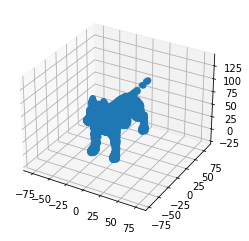

In [2]:
shape = TorchShape(filename=_args.filename, device=device)
shape.mesh.show()
shape.plot_embedding(shape.mesh.vertices)

d_mat_input = sio.loadmat(_args.d_mat_input)['D']

In [3]:
mds_params = MdsConfig.MdsParams(shape, _args)
mds_params.set_shape(shape)
mds_params.set_p_q(_args.p, _args.q)
mds_params.set_weights(np.ones(d_mat_input.shape))

[samples, d_mat] = shape.sample_mesh_fps(np.max(mds_params.q), d_mat_input)
mds_params.set_samples(samples)

sample_mesh



In [4]:
# create subspace
shape.compute_subspace(max(mds_params.p))
mds = TorchMDS(mds_params, device)
x0 = shape.mesh.vertices
var_type = torch.float64

phi = shape.evecs.type(var_type).to(device)
d_mat = torch.tensor(d_mat, dtype=var_type, device=device)
x0 = torch.tensor(x0, dtype=var_type, device=device)

start compute subspace


2022-07-20 17:27:00,229 - TorchMDS - INFO - PyTorch Logger


start algorithm
iter : 40, stress : 272788.10725678864
iter : 80, stress : 270087.90187973704
iter : 120, stress : 269847.12762191414
iter : 40, stress : 1021694.99218211
final stress : 1020825.3494526679
Forward
tensor([[ 1.8685, 47.5457, 58.5660],
        [ 3.1958, 47.1159, 58.0004],
        [ 4.0069, 44.7297, 43.0428],
        ...,
        [-4.1571, 78.5004, 91.5865],
        [-2.8169, 78.7025, 93.4736],
        [-5.4065, 77.6041, 91.5308]], device='cuda:0', dtype=torch.float64,
       grad_fn=<CloneBackward0>) tensor([[ 0.0000,  1.2119, 10.6272,  ..., 44.3709, 45.1510, 43.4997],
        [ 1.2119,  0.0000,  9.8112,  ..., 45.3745, 46.0701, 44.5426],
        [10.6766,  9.7942,  0.0000,  ..., 54.9201, 55.6756, 54.0532],
        ...,
        [44.2578, 45.3234, 54.8849,  ...,  0.0000,  3.9170,  3.4110],
        [44.7481, 45.6933, 55.3607,  ...,  2.5922,  0.0000,  4.5529],
        [43.3973, 44.5375, 54.0245,  ...,  3.7586,  4.5459,  0.0000]],
       device='cuda:0', dtype=torch.float64) t

C:\Users\adiw\PycharmProjects\SLS-MDS\MDS\MDS.py:29: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\adiw\PycharmProjects\SLS-MDS\implicit_function_torch.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xn = torch.tensor(self.mds.algorithm(self.d_mat, self.x0, self.phi), requires_grad=True).clone()


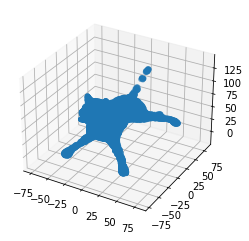

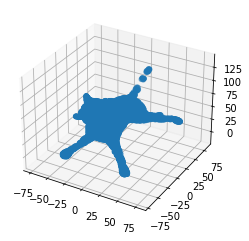

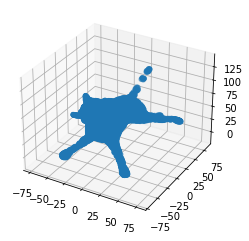

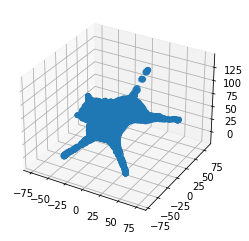

In [5]:
diff_mds = DifferentiableMDS(mds, x0, phi, d_mat)
xn = diff_mds.forward()

In [6]:
loss = sum(xn) ** 2
loss.backward()


Backward
(tensor([[328792.1875, 328792.1875, 328792.1875],
        [328792.1875, 328792.1875, 328792.1875],
        [328792.1875, 328792.1875, 328792.1875],
        ...,
        [328792.1875, 328792.1875, 328792.1875],
        [328792.1875, 328792.1875, 328792.1875],
        [328792.1875, 328792.1875, 328792.1875]], device='cuda:0',
       dtype=torch.float64),)
